# 2주차 BERT I/O만들기

https://github.com/huggingface/tokenizers

## corpus 불러오기 

In [1]:
from Korpora import Korpora
import pickle

In [2]:
# Korpora.fetch('namuwikitext')

In [3]:
# corpus = Korpora.load('namuwikitext')
# with open('../../file/kor.p', 'wb') as f:
#     pickle.dump(corpus, f)

In [4]:
with open('../../file/kor.p', 'rb') as f:
    corpus = pickle.load(f)

## tokenizer 학습 
`mecab`으로 자르고 공백으로 join 후에 `BPE`

In [5]:
import mecab
pos = mecab.MeCab()

In [6]:
import sys
sys.path.append('/home/long8v/torch_study/paper/05_ELMo/source')

In [7]:
from txt_cleaner.clean.master import MasterCleaner

In [8]:
cleaner = MasterCleaner({'minimum_space_count': 5})

In [9]:
train = corpus.train.texts

In [10]:
pos.morphs('안녕하세요')

['안녕', '하', '세요']

In [11]:
train_clean = [cleaner.cleaning(t) for t in train]
train_clean = [' '.join(pos.morphs(train)) for train in train_clean if train]

In [12]:
filepath = '/home/long8v/torch_study/paper/file'

In [13]:
with open(f'{filepath}/train.txt', 'w') as f:
    f.write('\n'.join(train_clean))

In [14]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

In [15]:
tokenizer = Tokenizer(BPE())

In [16]:
corpuspath = f"{filepath}/train.txt"

In [17]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])
tokenizer.train(files=[corpuspath], trainer=trainer)

In [18]:
corpus_dev = train_clean[:100]

In [19]:
output = tokenizer.encode_batch(['안녕하세요?', '반갑습니다'])
output[0].tokens

['안', '하', '세', '요', '?']

## BERT input 

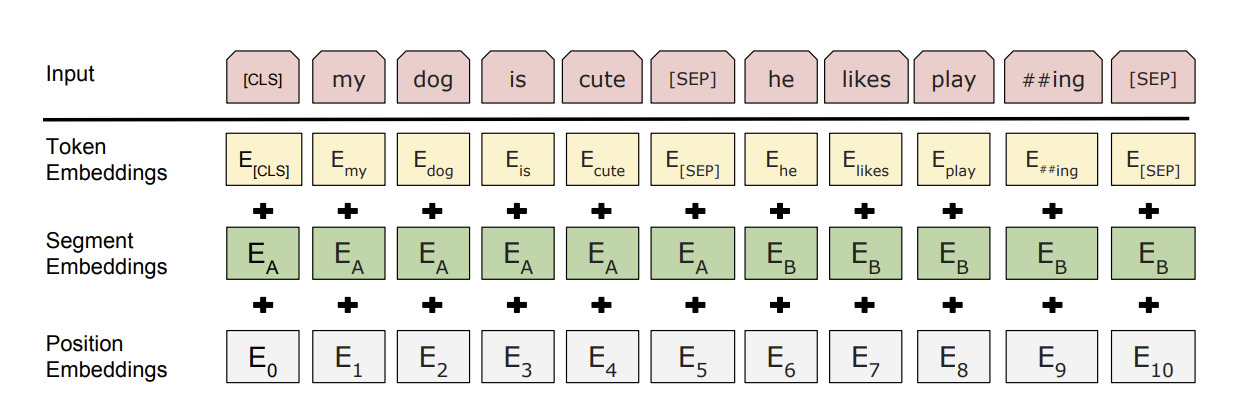

1) position embeddings를 위한 `position` 토큰<br>
2) 문장 앞에 `[CLS]` 토큰<br>
3) 문장 중간에 `[SEP]` 토큰<br>
4) 문장 끝에 `[SEP]`토큰<br>
5) 문단 전체에서 `max_len`으로 일단 자르기<br>
6) 연속된 문장이면 1, 아니면 0인 `NSP output`이 있어야 함<br> 
7) 반으로 잘라서 `segment embeddings`<br>
8) mask된 토큰을 알려주는 `mask_ids`<br>
9) 원래 토큰을 알려주는 `tokens`<br>
10) 변경된 토큰을 알려주는 `replace_tokens`

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
import random
import torch

In [22]:
vocab = tokenizer.get_vocab()
random_token = random.choice(list(vocab))
random_ids = vocab[random_token]
random_ids, random_token

(5625, 'mlic')

In [23]:
MASK_TOKEN = '<mask>'

In [24]:
tokenizer.add_special_tokens([MASK_TOKEN])

1

In [25]:
tokenizer.get_vocab()[MASK_TOKEN]

21293

In [26]:
import math

In [27]:
MAX_LEN = 16

In [28]:
class BERT_input:
    def __init__(self, vocab, senA, senB, isNext, max_len, masking_ratio=0.15, mask='<mask>'):
        self.vocab = vocab
        self.senA = senA
        self.senB = senB
        self.tokens = ['[CLS]'] + senA + ['[SEP]'] + senB + ['[SEP]']
        self.ids = [vocab[tok] for tok in self.tokens]
        self.segment_ids = [0 for _ in range(max_len // 2 + 2)] + [1 for _ in range(max_len // 2 + 1)]  # cls랑 sep은 a꺼 마지막은 b꺼
        self.isNext = isNext
        self.position = [_ for _ in range(max_len)] # for position embedding
        self.masking_ratio = masking_ratio 
        self.get_mask_token()
        self.mask = mask # mask token
        self.mask_ids = [1 if _ in self.mask_token else 0 for _ in range(len(self.tokens))] # mask 1, otherwise 0
        self.replaced_token = self.get_replaced_tokens() # 토큰을 치환하는 코드
        self.replaced_ids = [vocab[tok] for tok in self.replaced_token] # 치환한 코드의 index를 구하는 코드
        
    def get_mask_token(self):
        #  mask로 선택된 토큰 중 확률에 따라 [mask], random token, remain index를 구하는 코드
        def random_choice_with_prob(lst, p):
            k = round(len(lst) * p)
            return random.sample(lst, k=k)
        
        mask_token = random_choice_with_prob(self.position, p=self.masking_ratio)
        self.mask_token = mask_token[:]
        self.mask_mask = random_choice_with_prob(mask_token, p=0.8)
        for m in self.mask_mask:
            mask_token.remove(m)
        self.mask_replace = random_choice_with_prob(mask_token, p=0.5)
        for m in self.mask_replace:
            mask_token.remove(m)
        self.mask_remain = mask_token
    
    def get_replaced_tokens(self):      
        # 모든 토큰을 바꾸는 코드
        return [self.replace_token(ids, token) for ids, token in enumerate(self.tokens)]
  
    def replace_token(self, ids, token):
        # mask로 선택된 token 하나를 ids를 참고해서 바꾸는 코드 
        if ids in self.mask_mask:
            return self.mask
        elif ids in self.mask_replace:
            replaced = self.get_random_token()
            return replaced
        elif ids in self.mask_remain:
            return token
        return token

    def get_random_token(self):
        # random token을 추출하는 코드
        random_token = random.choice(list(self.vocab))
        return random_token

In [29]:
output[0]

Encoding(num_tokens=5, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [30]:
def split_list(lst, n ):
    return [lst[i:i+n] for i in range(0, len(lst), n)]

In [31]:
encoded = tokenizer.encode(corpus_dev[0])

In [32]:
def get_isNext_token(windows):
    return [(windows[i], windows[i+1]) for i in range(len(windows) - 1)]

In [33]:
windows = split_list(encoded.tokens, MAX_LEN)
yes_next = get_isNext_token(windows)

In [46]:
import random

In [56]:
a = [1, 3, 4, 5, 2]
random.shuffle(a)
a

[3, 1, 4, 5, 2]

In [57]:
class BERT_Dataset(Dataset):
    def __init__(self, corpus, tokenizer, max_len):
        self.corpus = corpus
        # 모든 문단에 대해 tokenize함
        self.corpus_tokenized = tokenizer.encode_batch(corpus)
        # 모든 문단을 max_len으로 잘라서 리스트로 만듦
        self.corpus_splitted = [self.split_list(corpus.tokens, max_len // 2) 
                                for corpus in self.corpus_tokenized]
        
        # 문단에서 인접한 애들을 튜플로 만들어서 yesNext리스트에 넣음
        # get pair IsNext yes, senA, senB
        self.yesNext = [self.get_neighbor_token(corpus) 
                        for corpus in self.corpus_splitted]
        self.yesNext = [(senA, senB, 1) 
                        for corpus in self.yesNext 
                        for senA, senB in corpus]
       
        # 현재 [[문장1, 문장2, ], ... ] 로 되어 있기 때문에 풀어줌
        self.coprus_flat = [c for corpus in self.corpus_splitted 
                            for c in corpus]
        
        # 섞은 뒤에 인접한 애들을 튜플로 묶어서 noNext리스트에 넣음 
        # -> yesNext인게 일부 있을 수 있음 어케 빼지..
        random.shuffle(self.coprus_flat)
        self.noNext = self.get_neighbor_token(self.coprus_flat)
        self.noNext = [(senA, senB, 0) for senA, senB in self.noNext]
        
        self.pair_data = self.yesNext + self.noNext
        self.vocab = tokenizer.get_vocab()
        self.max_len = max_len        
        
    def split_list(self, lst, n):
        return [lst[i:i+n] for i in range(0, len(lst), n)]
    
    def get_neighbor_token(self, windows):
        return [(windows[i], windows[i+1]) for i in range(len(windows) - 1)]
    
    def __len__(self):
        return len(self.corpus)
    
    def __getitem__(self, ids):
        senA, senB, isNext = self.pair_data[ids]
        bert_input = BERT_input(self.vocab, senA, senB, isNext, self.max_len, 0.5)
        return torch.Tensor(bert_input.ids), torch.Tensor(bert_input.mask_ids), torch.Tensor(bert_input.replaced_ids), torch.Tensor(bert_input.position), torch.Tensor(bert_input.segment_ids)

In [58]:
bd = BERT_Dataset(corpus_dev, tokenizer, MAX_LEN)
for ids, mask_ids, replaced_ids, position, segment_ids in bd:
    print(ids)
    print(position)
    print(mask_ids)
    print(replaced_ids)
    print(segment_ids)
    break

tensor([1.0000e+00, 2.1220e+04, 2.1127e+04, 2.0819e+04, 1.5928e+04, 8.4760e+03,
        3.1890e+03, 1.2950e+03, 6.1700e+02, 2.0000e+00, 1.0390e+03, 2.0000e+00])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.])
tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1.])
tensor([1.0000e+00, 2.1293e+04, 2.1127e+04, 2.0819e+04, 1.5928e+04, 8.4760e+03,
        3.1890e+03, 1.2950e+03, 2.1293e+04, 2.1293e+04, 2.1293e+04, 2.1293e+04])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.])


In [37]:
tokenizer.get_vocab()['[CLS]'], tokenizer.get_vocab()['[SEP]']

(1, 2)

In [38]:
from collections import namedtuple 
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

In [39]:
def pad_collate(batch):
    ids, mask_ids, replaced_ids, position, segment_ids = zip(*batch)
    named_tuple = namedtuple('data', ['ids', 'mask_ids', 'replaced_ids', 'position', 'segment_ids'])
    ids_pad = pad_sequence(ids, batch_first=True, padding_value=0)
    mask_ids_pad = pad_sequence(mask_ids, batch_first=True, padding_value=0)
    replaced_ids_pad = pad_sequence(replaced_ids, batch_first=True, padding_value=0)
    position_pad = pad_sequence(position, batch_first=True, padding_value=0)
    segment_ids = pad_sequence(segment_ids, batch_first=True, padding_value=0)
    return named_tuple(ids_pad, mask_ids_pad, replaced_ids_pad, position_pad, segment_ids)   

In [40]:
for batch in DataLoader(bd, collate_fn = pad_collate, batch_size=4):
    print(batch.ids)
    print(batch.mask_ids)
    print(batch.replaced_ids)
    print(batch.position)
    print(batch.segment_ids)
    break

tensor([[1.0000e+00, 2.1220e+04, 2.1127e+04, 2.0819e+04, 1.5928e+04, 8.4760e+03,
         3.1890e+03, 1.2950e+03, 6.1700e+02, 2.0000e+00, 1.0390e+03, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 1.9509e+04, 1.7189e+04, 1.7140e+04, 1.6913e+04, 1.6882e+04,
         1.6768e+04, 3.3790e+03, 1.0420e+03, 2.0000e+00, 1.1160e+03, 2.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 2.1212e+04, 2.1203e+04, 2.1114e+04, 2.0772e+04, 2.0644e+04,
         1.9941e+04, 1.4651e+04, 8.1980e+03, 2.0000e+00, 4.7700e+03, 2.5700e+02,
         1.5300e+02, 1.0390e+03, 2.0000e+00],
        [1.0000e+00, 2.1254e+04, 2.1155e+04, 2.0696e+04, 1.9126e+04, 1.8902e+04,
         1.7540e+04, 1.4609e+04, 6.8080e+03, 2.0000e+00, 1.7670e+03, 4.2230e+03,
         2.0000e+00, 0.0000e+00, 0.0000e+00]])
tensor([[1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.